In [1]:
import os
import json
import lib
import skimage.io as io
import numpy as np
import networkx as nx
from PIL import Image
import cv2
from skimage import color

In [9]:
img_path = "../inputData/input_data/2019-04-21_01020_nocover.jpg"
json_path = "../inputData/input_data/2019-04-21_01020.json"


with open(json_path, 'r') as f:
    data = json.load(f)
    labels = data['labels']
    species = ["0", "1", "2", "3", "4", "6"] #data['bacterias']
    coordinates = []
    classes = []
    alphas = {}
    scale = lib.translate_factor
    for label in labels:
        coordinates.append(lib.Coordinate(np.array([label['x'],label['x']+label['width'],\
                                                label['y'],label['y']+label['height']])))
        clas = label['class']
        if not clas.isnumeric(): clas = lib.category_id_dict[clas] 
        classes.append(clas)
    coordinates = [c*scale for c in coordinates]
    for c in coordinates: c.to_int()
    petri_image = io.imread(img_path)
    # io.imshow(petri_image)
    # print(img_path)
    adj_matrix = lib.adjacency_matrix_between_patches(coordinates)
    G = nx.from_numpy_matrix(adj_matrix) 
    connected_patches_list = list(nx.connected_components(G))
    patches_to_del = []
    patches_grouped_coordinates = {}
    for connected_patches in connected_patches_list:
        connected_patches = list(connected_patches)
        # print(connected_patches)
        if len(connected_patches) > 1: # overlapping
            # coordinates of extended patch
            ex1 = np.amin([coordinates[i].x1 for i in connected_patches])
            ex2 = np.amax([coordinates[i].x2 for i in connected_patches])
            ey1 = np.amin([coordinates[i].y1 for i in connected_patches])
            ey2 = np.amax([coordinates[i].y2 for i in connected_patches])
            # alpha channel for non-rectangular cropping of extended patch
            alpha_matrix = np.zeros((ex2-ex1,ey2-ey1), dtype=np.uint8)
            grouped_coordinates = []
            for i in connected_patches:
                alpha_matrix[coordinates[i].x1-ex1:coordinates[i].x2-ex1,
                                coordinates[i].y1-ey1:coordinates[i].y2-ey1] = 1
                grouped_coordinates.append(lib.Coordinate([coordinates[i].x1-ex1,\
                                                            coordinates[i].x2-ex1,\
                                                            coordinates[i].y1-ey1,\
                                                            coordinates[i].y2-ey1]))
            alphas[connected_patches[0]] = alpha_matrix
            patches_grouped_coordinates[connected_patches[0]] = grouped_coordinates
            # extended patch
            coordinates[connected_patches[0]] = lib.Coordinate([ex1,ex2,ey1,ey2])
            patches_to_del.extend(connected_patches[1:])
        else:
            c = coordinates[connected_patches[0]]
            alphas[connected_patches[0]] = np.ones((c.x2-c.x1,c.y2-c.y1), dtype=np.uint8)
            patches_grouped_coordinates[connected_patches[0]] = [lib.Coordinate([0,c.x2-c.x1,0,c.y2-c.y1])]

    coordinates = lib.del_multiple(coordinates, patches_to_del)
    classes = lib.del_multiple(classes, patches_to_del)
    alphas = [alphas[a] for a in sorted(alphas)] # to arrange alpha matrices in the same order as coordinates
    patches_grouped_coordinates = [patches_grouped_coordinates[c] for c in sorted(patches_grouped_coordinates)]


    # size_x = petri_image.shape[0]
    # size_y = petri_image.shape[1]
    # size_c = petri_image.shape[2]
    # b = color.rgb2lab(petri_image[:,:,:3])[:,:,2] # b in Lab colorspace 
    # io.imsave(os.path.join("test/CIElab","random.jpg"),b)
    for ic, (classe,coordinate) in enumerate(zip(classes,coordinates)):
        patch_image = petri_image[coordinate.y1:coordinate.y2,coordinate.x1:coordinate.x2]
        # io.imshow(petri_image)

        # join alphas                    
        alpha_from_bboxes = alphas[ic].transpose()
        # io.imshow(alpha_from_bboxes)

        try:
           

            alpha_from_seg = lib.get_alpha_from_segmentation(patch_image)
            # io.imshow(alpha_from_seg)
            alpha_from_blending = lib.get_alpha_from_blending_with_backgroung(patch_image, alpha_from_seg, alpha_from_bboxes)
      
        except ValueError: 
            print("ValueError")
            continue
        # join three alpha-matrices
        alpha_matrix = np.multiply(alpha_from_seg, alpha_from_bboxes)

        alpha_matrix = np.multiply(alpha_from_blending, alpha_matrix)
        io.imsave(os.path.join("test",str(ic)+".png"),alpha_matrix)

        #
        patch_image = np.dstack((patch_image, alpha_matrix)) # add alpha channel

        # io.imshow(petri_image)
        # test_dir = "test"
        # specie_patch_dir = os.path.join(test_dir, classe)
        # img_name = "test"
        # if not os.path.exists(os.path.join(specie_patch_dir, img_name)): os.mkdir(os.path.join(specie_patch_dir,img_name))
        # io.imsave(os.path.join(specie_patch_dir, img_name + ".png"), patch_image)
        # # write json with proper bboxes     
        # with open(os.path.join(specie_patch_dir, img_name + "_" + str(ic) + ".json"), 'w') as jf:
        #     json.dump(lib.bbox_dict(patches_grouped_coordinates[ic],classe), jf)


In [3]:
from skimage.morphology import dilation
import random as rnd

In [4]:
size_x = petri_image.shape[0]
size_y = petri_image.shape[1]
size_c = petri_image.shape[2]
b = color.rgb2lab(petri_image[:,:,:3])[:,:,2] # b in Lab colorspace 
io.imsave(os.path.join("test/CIElab","b.jpg"),b)
L = color.rgb2lab(petri_image[:,:,:3])[:,:,0] # luminance in Lab colorspace

# result = lib.filter_patch(petri_image,remove_labels=True)
io.imsave(os.path.join("test/CIElab","l.jpg"),L)
dark_matter_threshold = 5
colonies_threshold = 30
dark_regions_threshold = 25

if size_c == 3: petri_image[np.logical_and(L <= dark_matter_threshold, b < colonies_threshold)] = [1.,1.,1.]
if size_c == 4: petri_image[np.logical_and(L <= dark_matter_threshold, b < colonies_threshold)] = [1.,1.,1.,0.]
# 
mask = np.zeros_like(petri_image[:,:,0], dtype=np.uint8)
# detect dark regions via luminance and b-value thresholing
mask[np.logical_and.reduce((L > dark_matter_threshold, L < dark_regions_threshold, b < colonies_threshold))] = 1 
# dilate mask for better coverage of dark regions
dilation_steps = int(np.sqrt(size_x*size_y)/64) # 36 # 128 # 256
if dilation_steps > 16: dilation_steps = 16
for i in range(dilation_steps): mask = dilation(mask) 
where_mask = np.where(mask==1) 
for i0,j0 in zip(where_mask[0],where_mask[1]):
    i = i0
    j = j0
    step = 2 # random walk starting step
    while mask[i,j]==1 and step < size_x and step < size_y: # random walk
        direction = int(rnd.random()*4)
        if direction == 0 and i < size_x-step: i += step
        elif direction == 1 and j < size_y-step: j += step
        elif direction == 2 and i > step-1: i -= step
        elif j > step-1: j -= step
        step += 2
    petri_image[i0,j0,:] = petri_image[i,j,:]
io.imsave(os.path.join("test/CIElab","filter.jpg"),petri_image)

Lossy conversion from float64 to uint8. Range [-5.570121325878724, 65.32240124563948]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.2543866689892553, 81.51891697234521]. Convert image to uint8 prior to saving to suppress this warning.


In [5]:
chan = lib.segment_patch (petri_image)
io.imsave(os.path.join("test/CIElab","filter1.jpg"),chan)


C:\Users\GTT\AppData\Local\Temp/ipykernel_24724/3730532857.py:2: UserWarning: test/CIElab\filter1.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join("test/CIElab","filter1.jpg"),chan)


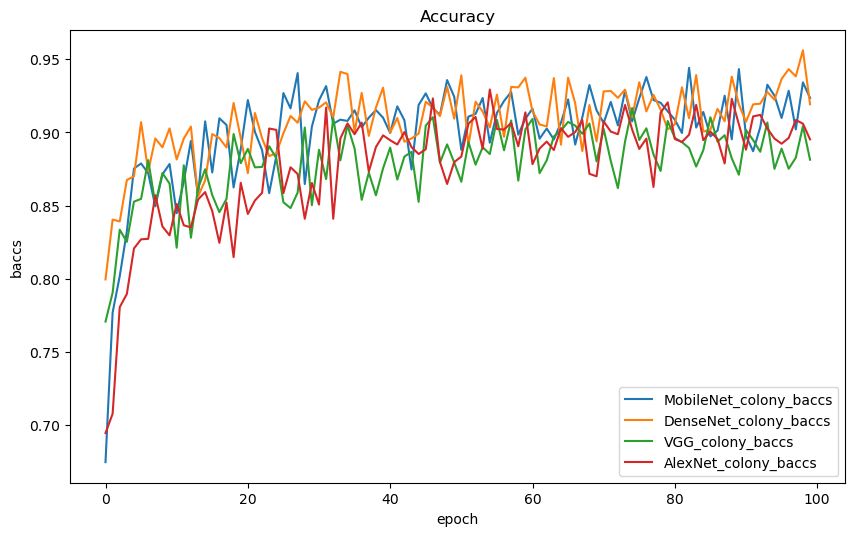

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
# test = [0.123394732,2]

AlexNet_colony_baccs =  [0.6945881566085301, 0.707704378247672, 0.7806045171579976, 0.7896038483305038, 0.8207403405875391, 0.8269689252456655, 0.8272791583063231, 0.8571047486752071, 0.8357125585224058, 0.8296684159078047, 0.8510752688172044, 0.8365421618562536, 0.8351183310181612, 0.854125636672326, 0.8592416525183928, 0.8462195812110922, 0.8245444255800791, 0.8521279003961517, 0.8147834027884961, 0.865557441992077, 0.8443090497504759, 0.8535200905489532, 0.8587233112105779, 0.9026791685959769, 0.9017657045840408, 0.8585398981324278, 0.8762195812110922, 0.8715619694397283, 0.8409960384833051, 0.8654499151103565, 0.8507130730050934, 0.9170288624787777, 0.8410040129649637, 0.8958404074702887, 0.9061799660441426, 0.8987832484436898, 0.9067062818336163, 0.8732371250707412, 0.8900113186191284, 0.8980215568246128, 0.8946689303904923, 0.8917657045840407, 0.9002546689303905, 0.8899717034521789, 0.8852744765138653, 0.8885002829654782, 0.9232371250707413, 0.8797363276225756, 0.8647957503729999, 0.8797363276225756, 0.8835200905489529, 0.9059445902145393, 0.9105772495755519, 0.8887832484436899, 0.9293491794001131, 0.9023316355404642, 0.9020090548953028, 0.9064629315223544, 0.8905376344086022, 0.9137238256932655, 0.8783045223028246, 0.8890265987549519, 0.8937634408602151, 0.8879819416576632, 0.9029621340741883, 0.8969892473118278, 0.9002546689303905, 0.9085002829654781, 0.8717260894170911, 0.8700113186191285, 0.9075551782682514, 0.9005772495755519, 0.8987832484436898, 0.9187436332767402, 0.9020090548953028, 0.8887436332767402, 0.8958007923033389, 0.8627187837629263, 0.9134804753820035, 0.9205376344086023, 0.8955178268251274, 0.8934804753820034, 0.8984606677985287, 0.9188228636106395, 0.8947085455574421, 0.9005376344086022, 0.8955178268251274, 0.8787832484436897, 0.9230017492411381, 0.9055178268251274, 0.8882649071358749, 0.9109643977980142, 0.9120090548953026, 0.9027187837629264, 0.8958007923033389, 0.8922920203735144, 0.8962275556927508, 0.9085002829654781, 0.9059921798631475, 0.8952744765138654]

MobileNet_colony_baccs = [0.674678076161127, 0.7768941839704552, 0.8017726294421209, 0.8324580551275467, 0.8753825176706531, 0.8787952160833516, 0.8721549636803875, 0.8495022867904225, 0.8713674272996308, 0.8784405801354953, 0.8448186465135616, 0.8665297038178394, 0.8942618069312985, 0.8565369188250544, 0.9075769804583362, 0.8726636828331744, 0.9096730011984249, 0.9051287695355492, 0.8624159268227064, 0.8885342529410327, 0.9221537407978087, 0.9003668647736444, 0.8879426834935309, 0.8585173771614449, 0.883772348179128, 0.9269156455597134, 0.916452662215374, 0.9405532320786557, 0.8647271748966663, 0.9040008437889794, 0.9219385134639371, 0.9316775503216181, 0.9059921246361924, 0.9087338273778951, 0.9078704722772519, 0.9150830337271015, 0.9035414679482475, 0.9101059016313254, 0.915298261060973, 0.9101059016313254, 0.8996429182869861, 0.9178247364688044, 0.9083033727101524, 0.8746814390882186, 0.918792831462323, 0.926700418225842, 0.916452662215374, 0.9121236578863698, 0.935791327316751, 0.9243891701518822, 0.8880520091960769, 0.9108298481179837, 0.9126323770391567, 0.9235258150512387, 0.8930026658840218, 0.9133563235258151, 0.9215080587961945, 0.9276395920463717, 0.8984885171325849, 0.9093819551446669, 0.9162374348815028, 0.8957443686257246, 0.9026781128476042, 0.8951745053439968, 0.9067160711228508, 0.9225866412307091, 0.8917088561156359, 0.9103211289651967, 0.9324014968082764, 0.9151588524469879, 0.9065008437889794, 0.9208599310294225, 0.9048352777166336, 0.928502947147015, 0.907579426223494, 0.9233105877173674, 0.9378873480568396, 0.9221537407978087, 0.9202753931567491, 0.9144349059603296, 0.9087338273778951, 0.8996429182869861, 0.9441582899210019, 0.9033262406143763, 0.9140044512925869, 0.8973316702130262, 0.9012302198742876, 0.9251131166385402, 0.8953139139579818, 0.9432949348203585, 0.8977009807518282, 0.8871621786876023, 0.9035414679482475, 0.9326167241421478, 0.9251131166385402, 0.909890674297454, 0.928502947147015, 0.9020935749749309, 0.9342040257294494, 0.9235258150512387]
DenseNet_colony_baccs = [0.799561633416587, 0.8404611842578603, 0.8392074969422261, 0.8675143638288467, 0.8700599220910036, 0.9069962895583444, 0.8734300001027823, 0.8958690244930262, 0.8898269659687748, 0.9027602191319005, 0.8815297092288243, 0.8958069953645176, 0.9039874400008223, 0.8563136094066376, 0.867189211967973, 0.8989022334597557, 0.8961251580278129, 0.889710153865129, 0.9201727770754321, 0.8963136094066376, 0.872167884637127, 0.9132815824365575, 0.8960186241559003, 0.8838926233130853, 0.8857489233552259, 0.899459159446209, 0.9112284028655709, 0.9066465213324699, 0.9212735756940376, 0.9154328677294359, 0.9169827222924567, 0.9205541508638854, 0.910379266750948, 0.9414433206911083, 0.9399166435406453, 0.900204382638011, 0.9270278951209235, 0.897638935997451, 0.9170459334176149, 0.930599323692352, 0.8999482491032242, 0.9098482932996209, 0.893686133637569, 0.8958690244930262, 0.8992288242730722, 0.9209987357774969, 0.9170143278550359, 0.9112052254530131, 0.9312052254530132, 0.9094037083860093, 0.9390359018634434, 0.8910986915811006, 0.9209987357774969, 0.9143004635482512, 0.9034564665494947, 0.9258638853771597, 0.8969827222924568, 0.9310986915811004, 0.9308238516645597, 0.9374273072060684, 0.9145120923396339, 0.9054509060261273, 0.9041255794353139, 0.9371711736712814, 0.8916413822166035, 0.9374273072060684, 0.9199166435406454, 0.8872711294748852, 0.9187526337968815, 0.8938874841972186, 0.928078381795196, 0.9283216161491576, 0.9236493889591234, 0.9292423915389596, 0.9103476611883693, 0.9342688579856722, 0.9143636746734092, 0.925670962967531, 0.9156573957016434, 0.9021627455212604, 0.9055141171512853, 0.9308238516645597, 0.9096785483025499, 0.939197218710493, 0.9005541508638852, 0.9018794774546987, 0.916133586177834, 0.9076337968815844, 0.9381467320362205, 0.919165613147914, 0.9072524230931311, 0.9191972187104931, 0.9196734091866835, 0.9276970080067425, 0.92232406236831, 0.9365652719106204, 0.9432448377581121, 0.9383164770332912, 0.956133586177834, 0.919260429835651]
VGG_colony_baccs =  [0.7707384179051745, 0.7904624068142687, 0.8335221353569977, 0.8252270665114703, 0.8527026490329241, 0.854594640833173, 0.8810813040170838, 0.851158016295631, 0.8722140245076024, 0.8650175512560834, 0.8212044835898047, 0.877551805992173, 0.8280483862243171, 0.8618506875387609, 0.8748208977566776, 0.8571822672740105, 0.8455034262373712, 0.8545613407998729, 0.8989435640811788, 0.879010286349736, 0.8887705566604648, 0.8761532045935716, 0.8764128837523334, 0.890605419045786, 0.8823537318950162, 0.8522639260361873, 0.8482847427801555, 0.8589102029469002, 0.903369107956264, 0.8503026025961805, 0.8881845982763416, 0.8681080387502407, 0.9096597592010436, 0.8809285515707534, 0.9049678150595583, 0.8889972412908194, 0.853948803490088, 0.8724834798229294, 0.8570490491699342, 0.8754239644147901, 0.8896430786339045, 0.8677915356814438, 0.883492654134856, 0.8867261179187785, 0.8525502020914864, 0.9046748358674964, 0.9103889993798251, 0.879386668377494, 0.8918307991702488, 0.8794367711798905, 0.8663330553238809, 0.8933128034045467, 0.8779880669788926, 0.8899027577926659, 0.8852441136844806, 0.9086375398302003, 0.8878082162485832, 0.9082012788434808, 0.8670622955026625, 0.9021107333033939, 0.9092234982143239, 0.8721905006308676, 0.8809285515707534, 0.8972755073672506, 0.9012980902889159, 0.9071790594726374, 0.9046748358674964, 0.8991103697525716, 0.9060734372660978, 0.8801993113919719, 0.9023704124621557, 0.8804922905840336, 0.8619340903744573, 0.8936891854323047, 0.9167062295502664, 0.894854686597806, 0.9028399734821754, 0.8849511344924188, 0.8736725048651653, 0.9078248968157225, 0.8962532879964072, 0.8933629062069428, 0.8893500994418424, 0.8766728684159876, 0.8878583190509796, 0.9103792232232599, 0.8936891854323047, 0.8980881503817283, 0.8823271529693548, 0.8711084023010628, 0.9016411722833741, 0.8947712837621096, 0.8867859968777398, 0.9068026774448793, 0.8750976851894283, 0.888913838455123, 0.8751810880251247, 0.8827634139560745, 0.9042385748807767, 0.881364812557473]

plt.figure(figsize=(10,6),dpi=100)
plt.plot(MobileNet_colony_baccs,label='MobileNet_colony_baccs')
plt.plot(DenseNet_colony_baccs,label='DenseNet_colony_baccs')
plt.plot(VGG_colony_baccs,label='VGG_colony_baccs')
plt.plot(AlexNet_colony_baccs,label='AlexNet_colony_baccs')
plt.xlabel('epoch')
plt.ylabel('baccs')
plt.legend()
plt.title('Accuracy')
plt.show()

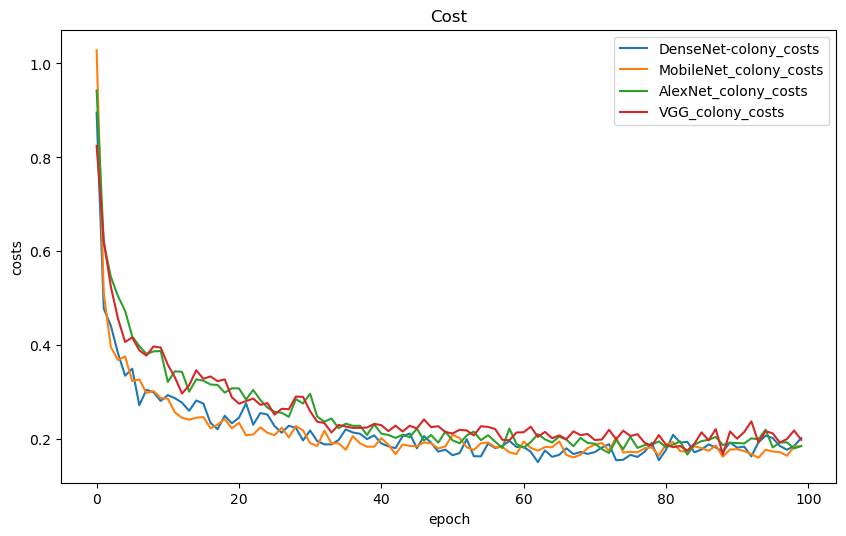

In [21]:
costs = [0.8955483938518324, 0.4780793103732561, 0.44153197815543727, 0.38307718285604525, 0.33530368999038873, 0.35041986910724326, 0.2725920886977723, 0.3054333429195379, 0.2999751390889287, 0.28157511029980686, 0.29392363983941705, 0.2874480966282518, 0.2778386324644089, 0.26051651274687365, 0.28255317183701617, 0.2759661373290184, 0.23472358771648846, 0.22151472230784988, 0.2499727128857845, 0.23392941324824565, 0.24583627322786733, 0.27652818557659264, 0.2308342110757765, 0.25577554964509447, 0.2526247912625733, 0.22791185041301346, 0.21391062325748958, 0.22871225268432968, 0.22416879555308505, 0.19756614193810443, 0.21856399919641645, 0.19604441236802622, 0.18910166599150552, 0.1890271047718431, 0.198380942995611, 0.22107817671310745, 0.21435221260119425, 0.2116719567167916, 0.20038931150185435, 0.20828506149547665, 0.19124665523045942, 0.18483663529255673, 0.18108988303299012, 0.20658761419748006, 0.2121078756784922, 0.18080995447541537, 0.2067105031915401, 0.19268038903215998, 0.1735787174517387, 0.17787887864305, 0.16601211947732067, 0.17043870552688054, 0.20020106228950776, 0.16385376330857215, 0.16359276611259893, 0.19094018628330608, 0.18117508257886297, 0.18544326823106722, 0.19658248315222168, 0.18361253997212962, 0.1836237929712393, 0.173427039659337, 0.1512837064893622, 0.17621955971576667, 0.16257276175249563, 0.16686660990020946, 0.18074405159016974, 0.16842934570128196, 0.1728259449775674, 0.16875133058056235, 0.17262061822571254, 0.18236292232024043, 0.18945941902501018, 0.15526277819452317, 0.15639587234411584, 0.16677813920633575, 0.16226571692938083, 0.17348351868751802, 0.19223226035798066, 0.15546323121280262, 0.17736972339059176, 0.20948404017345687, 0.19272914516592496, 0.1946377173850411, 0.1722034224505095, 0.17806462117617852, 0.18917519138439706, 0.18233335726453284, 0.1740502430322139, 0.19327561630818405, 0.18206800790013453, 0.18422972540812274, 0.16348655423835703, 0.19365214531947123, 0.20761770774659358, 0.20251480708094804, 0.18577014306854261, 0.17761052441538164, 0.18546584606366723, 0.2024495572734036] 
# AlexNet_colony_baccs = [0.5710743801652892, 0.7074380165289256, 0.7322314049586777, 0.775206611570248, 0.7801652892561983, 0.7876033057851239, 0.7966942148760331, 0.812396694214876, 0.8090909090909091, 0.7925619834710744, 0.8504132231404958, 0.8198347107438017, 0.8330578512396695, 0.8553719008264463, 0.8322314049586776, 0.8330578512396695, 0.8603305785123967, 0.8528925619834711, 0.8545454545454545, 0.8479338842975207, 0.8553719008264463, 0.856198347107438, 0.8504132231404958, 0.8661157024793389, 0.8636363636363636, 0.8619834710743801, 0.8760330578512396, 0.8776859504132232, 0.8760330578512396, 0.8661157024793389, 0.8413223140495868, 0.8743801652892562, 0.8900826446280992, 0.8892561983471075, 0.8842975206611571, 0.8958677685950414, 0.8859504132231405, 0.8909090909090909, 0.8983471074380165, 0.8900826446280992, 0.8917355371900827, 0.9082644628099174, 0.903305785123967, 0.8958677685950414, 0.9082644628099174, 0.8942148760330578, 0.9024793388429752, 0.903305785123967, 0.9024793388429752, 0.8991735537190083, 0.9041322314049587, 0.9049586776859504, 0.9008264462809917, 0.8900826446280992, 0.9, 0.8950413223140495, 0.9082644628099174, 0.9099173553719008, 0.8900826446280992, 0.9008264462809917, 0.9107438016528926, 0.9041322314049587, 0.8933884297520661, 0.9099173553719008, 0.9074380165289256, 0.8983471074380165, 0.912396694214876, 0.9066115702479339, 0.9057851239669421, 0.9066115702479339, 0.9148760330578513, 0.9132231404958677, 0.9049586776859504, 0.912396694214876, 0.9016528925619834, 0.9082644628099174, 0.9181818181818182, 0.9066115702479339, 0.9148760330578513, 0.9082644628099174, 0.9181818181818182, 0.912396694214876, 0.9107438016528926, 0.9190082644628099, 0.9198347107438016, 0.9148760330578513, 0.9041322314049587, 0.9082644628099174, 0.9074380165289256, 0.9016528925619834, 0.9041322314049587, 0.9115702479338843, 0.9090909090909091, 0.903305785123967, 0.8983471074380165, 0.912396694214876, 0.9, 0.9090909090909091, 0.9074380165289256, 0.912396694214876] [0.6501650165016502, 0.6864686468646864, 0.8085808580858086, 0.8052805280528053, 0.7854785478547854, 0.8316831683168316, 0.7887788778877888, 0.8052805280528053, 0.7788778877887789, 0.8184818481848185, 0.8250825082508251, 0.8679867986798679, 0.858085808580858, 0.8745874587458746, 0.8448844884488449, 0.8613861386138614, 0.8316831683168316, 0.858085808580858, 0.8217821782178217, 0.8877887788778878, 0.8415841584158416, 0.8778877887788779, 0.8448844884488449, 0.900990099009901, 0.8910891089108911, 0.8745874587458746, 0.8712871287128713, 0.858085808580858, 0.8415841584158416, 0.8382838283828383, 0.8415841584158416, 0.9042904290429042, 0.858085808580858, 0.900990099009901, 0.8910891089108911, 0.900990099009901, 0.9075907590759076, 0.8811881188118812, 0.8844884488448845, 0.8877887788778878, 0.8976897689768977, 0.8877887788778878, 0.900990099009901, 0.8943894389438944, 0.8910891089108911, 0.8943894389438944, 0.8976897689768977, 0.8943894389438944, 0.8745874587458746, 0.8943894389438944, 0.8877887788778878, 0.8943894389438944, 0.8976897689768977, 0.8976897689768977, 0.9174917491749175, 0.8976897689768977, 0.9042904290429042, 0.8943894389438944, 0.900990099009901, 0.9207920792079208, 0.8844884488448845, 0.9108910891089109, 0.9042904290429042, 0.8943894389438944, 0.9042904290429042, 0.9075907590759076, 0.900990099009901, 0.900990099009901, 0.8910891089108911, 0.8778877887788779, 0.9174917491749175, 0.8943894389438944, 0.900990099009901, 0.9174917491749175, 0.9042904290429042, 0.9075907590759076, 0.9108910891089109, 0.8778877887788779, 0.9075907590759076, 0.9108910891089109, 0.9075907590759076, 0.900990099009901, 0.9075907590759076, 0.8976897689768977, 0.8877887788778878, 0.9042904290429042, 0.9075907590759076, 0.8943894389438944, 0.900990099009901, 0.9108910891089109, 0.8976897689768977, 0.8910891089108911, 0.9075907590759076, 0.8910891089108911, 0.9108910891089109, 0.9042904290429042, 0.8943894389438944, 0.900990099009901, 0.900990099009901, 0.8943894389438944] [0.6945881566085301, 0.707704378247672, 0.7806045171579976, 0.7896038483305038, 0.8207403405875391, 0.8269689252456655, 0.8272791583063231, 0.8571047486752071, 0.8357125585224058, 0.8296684159078047, 0.8510752688172044, 0.8365421618562536, 0.8351183310181612, 0.854125636672326, 0.8592416525183928, 0.8462195812110922, 0.8245444255800791, 0.8521279003961517, 0.8147834027884961, 0.865557441992077, 0.8443090497504759, 0.8535200905489532, 0.8587233112105779, 0.9026791685959769, 0.9017657045840408, 0.8585398981324278, 0.8762195812110922, 0.8715619694397283, 0.8409960384833051, 0.8654499151103565, 0.8507130730050934, 0.9170288624787777, 0.8410040129649637, 0.8958404074702887, 0.9061799660441426, 0.8987832484436898, 0.9067062818336163, 0.8732371250707412, 0.8900113186191284, 0.8980215568246128, 0.8946689303904923, 0.8917657045840407, 0.9002546689303905, 0.8899717034521789, 0.8852744765138653, 0.8885002829654782, 0.9232371250707413, 0.8797363276225756, 0.8647957503729999, 0.8797363276225756, 0.8835200905489529, 0.9059445902145393, 0.9105772495755519, 0.8887832484436899, 0.9293491794001131, 0.9023316355404642, 0.9020090548953028, 0.9064629315223544, 0.8905376344086022, 0.9137238256932655, 0.8783045223028246, 0.8890265987549519, 0.8937634408602151, 0.8879819416576632, 0.9029621340741883, 0.8969892473118278, 0.9002546689303905, 0.9085002829654781, 0.8717260894170911, 0.8700113186191285, 0.9075551782682514, 0.9005772495755519, 0.8987832484436898, 0.9187436332767402, 0.9020090548953028, 0.8887436332767402, 0.8958007923033389, 0.8627187837629263, 0.9134804753820035, 0.9205376344086023, 0.8955178268251274, 0.8934804753820034, 0.8984606677985287, 0.9188228636106395, 0.8947085455574421, 0.9005376344086022, 0.8955178268251274, 0.8787832484436897, 0.9230017492411381, 0.9055178268251274, 0.8882649071358749, 0.9109643977980142, 0.9120090548953026, 0.9027187837629264, 0.8958007923033389, 0.8922920203735144, 0.8962275556927508, 0.9085002829654781, 0.9059921798631475, 0.8952744765138654]
MobileNet_colony_costs = [1.0280675746892627, 0.5112535247677251, 0.39612411707639694, 0.36876598078953593, 0.376369803359634, 0.32380121279703944, 0.32757687490237386, 0.29849317630654887, 0.30261648093399246, 0.28784832436787455, 0.28646251833752584, 0.25713271079094785, 0.24571184500267632, 0.24167565432818314, 0.2457632465582145, 0.24736220860167554, 0.22332902468348803, 0.231130148823324, 0.242828750100575, 0.2233191144309546, 0.23500368234358335, 0.20840657365165258, 0.21016031974240354, 0.22520583632745242, 0.21384500829797043, 0.2084903032764008, 0.22451127987158925, 0.20401769758839355, 0.2280064442832219, 0.21885447184506215, 0.1917788202041074, 0.1856984023592974, 0.21845395686595062, 0.19110393622203878, 0.19161485645331836, 0.1776836368402368, 0.20665694047745906, 0.19137023095237582, 0.184117890894413, 0.18417953935108686, 0.20231488111772036, 0.18852113814730392, 0.16833465781651044, 0.18881076888034218, 0.18586075423579468, 0.18495558947324753, 0.19326880829114662, 0.19113836211985663, 0.18032360174938253, 0.18468596256877245, 0.2094426282534474, 0.20266103460208365, 0.18298422290306343, 0.1771628546871637, 0.19136259057804159, 0.19323885538860372, 0.1827573488025289, 0.18374542264561905, 0.17212869991597377, 0.1683802396843308, 0.19509322862876088, 0.18173402155700483, 0.17553770502931193, 0.18347087580906718, 0.18306126935701622, 0.1954715973452518, 0.16642369104451255, 0.16139959043970234, 0.16696820545353389, 0.18133589419487275, 0.1884616960428263, 0.19190002987651447, 0.17557331723602196, 0.20373751134856752, 0.17169588588570295, 0.1731663961943827, 0.17206425523679508, 0.18083159929435505, 0.18245910392387918, 0.16520435088559202, 0.18888936221207442, 0.19407798840027107, 0.17458669762862356, 0.17354798552237058, 0.18506839547894502, 0.18109073205605933, 0.17538393033962502, 0.18683306696383575, 0.1627734770116053, 0.17813504859805107, 0.17872215542746217, 0.1747861475144562, 0.16840425653285102, 0.16059069413887828, 0.1777197300995651, 0.1739496473026903, 0.17257566171649255, 0.16500414084447057, 0.18364404906567774, 0.18591473790767946] 
AlexNet_colony_costs = [0.942651977664546, 0.6174221752505553, 0.5456726862803886, 0.5046181714064196, 0.47357666198360293, 0.41890629988751915, 0.3982360708086114, 0.38172248329379055, 0.38701609355446537, 0.3879791251138637, 0.3220821112198265, 0.3448065650698386, 0.34340488940085234, 0.30131663534006004, 0.3275004634143491, 0.32472733025880235, 0.3165352187658611, 0.31554132498996823, 0.29920237697660923, 0.3085064413516145, 0.3082394832255025, 0.2846842158193651, 0.30499156804657296, 0.2838670959402072, 0.26734779216349125, 0.25827505910082865, 0.2564117111951897, 0.24767408069027097, 0.28546199790741267, 0.27617324540685667, 0.29702178227077974, 0.2479664687753508, 0.23741056255408025, 0.24422374083415457, 0.22347899320486345, 0.23318042571803457, 0.22867237256937906, 0.22869427026690622, 0.20912751741707325, 0.2317822792224194, 0.21205912148089787, 0.20915717964893893, 0.20279818180164225, 0.20954989046348552, 0.20437072366966227, 0.2226338216446732, 0.19739150383362644, 0.20909064214088416, 0.1927179293707013, 0.2162500978447497, 0.19773301624349857, 0.19145539192188726, 0.20797805213614515, 0.21618300041575966, 0.19796834069941388, 0.20860659032079734, 0.19496210213554532, 0.1813980631138149, 0.22269751866789242, 0.18995301949938662, 0.18204262735028015, 0.19387532648091255, 0.21084656024743853, 0.1998125068157127, 0.19312939996291933, 0.2055310598133426, 0.1992434484786109, 0.18526593041851333, 0.20283058520994687, 0.19203525752221284, 0.19069494101169862, 0.17905868712420525, 0.17069209371938518, 0.1985572997088495, 0.17903709823363706, 0.20522124153610907, 0.18165083538348736, 0.1874355610558077, 0.18843282590081034, 0.19535249780471386, 0.18294493503574477, 0.1886900117571809, 0.19547669128759912, 0.1674728133764706, 0.18872050833153098, 0.19600316293929754, 0.19879804875113463, 0.2049568113625834, 0.18770518406343303, 0.19247396883407705, 0.1918245266730848, 0.1910475269205084, 0.20195581170877344, 0.19999128212466052, 0.2204721792552032, 0.18261155047404923, 0.1927975038997829, 0.193502901072957, 0.18058835538594345, 0.18526442260726503]
VGG_colony_costs = [0.824833440937494, 0.6225182453268453, 0.5247629651505696, 0.4567977054730842, 0.40700264667209823, 0.416758069866582, 0.3892577148385738, 0.3780578000372962, 0.39751377495888035, 0.39525223190062925, 0.35876503959298134, 0.33170563070789766, 0.297195816608636, 0.3149131159053037, 0.34695749151471417, 0.3286996697026648, 0.3337320338346456, 0.32360093746530383, 0.3275190047723682, 0.28934107642424733, 0.27576151622557327, 0.28124563979279055, 0.2867367801893699, 0.27334056990711314, 0.27697039944560903, 0.25236630278002276, 0.26494061245926115, 0.26382775580216394, 0.29082897795658363, 0.2902585752798538, 0.2595614960515185, 0.237260895781219, 0.23460664051143745, 0.21444081034707396, 0.23046259099225463, 0.22713828106459819, 0.224166501215414, 0.22422036474668666, 0.224972482550105, 0.23279423114696615, 0.22992526722679796, 0.21731364702511774, 0.22893136994619118, 0.21647633775137365, 0.22873513577015778, 0.22299056578623622, 0.242222251811702, 0.2257581366422145, 0.22773169157536408, 0.21554019880530081, 0.21225350742277346, 0.22004571047268415, 0.2186915681844479, 0.20822104380318993, 0.227663348477922, 0.2262897439006912, 0.22171329412805407, 0.19889772163802072, 0.19790217363716742, 0.21430756310981355, 0.2149151325421898, 0.2267580305373198, 0.20496577041615782, 0.2157070265690747, 0.20218053543450018, 0.20818536498240733, 0.19996296036008157, 0.2167842027143036, 0.20876193453410738, 0.21120584202244094, 0.19829779057028263, 0.199471350318115, 0.22011017568997646, 0.2000084262047159, 0.21819813623044051, 0.20694257225841284, 0.2107202645244175, 0.1925173208705689, 0.18625957023744522, 0.2088808195028258, 0.1884460709989071, 0.1830079287388607, 0.1856390269669263, 0.1759385925129448, 0.1904834134406165, 0.21475153092883134, 0.19757163357969962, 0.2216068849849858, 0.16780799990029713, 0.2165720233644702, 0.20122167816091524, 0.21550372583595545, 0.23810520841691055, 0.19323888048529625, 0.21716934106753846, 0.2125640304170941, 0.19302073116169163, 0.200464635205112, 0.21861656529730872, 0.19879462060175443] 
plt.figure(figsize=(10,6),dpi=100)
plt.plot(costs,label='DenseNet-colony_costs')
plt.plot(MobileNet_colony_costs,label='MobileNet_colony_costs')
plt.plot(AlexNet_colony_costs,label='AlexNet_colony_costs')
plt.plot(VGG_colony_costs,label='VGG_colony_costs')

plt.xlabel('epoch')
plt.ylabel('costs')
plt.legend()
plt.title('Cost')
plt.show()